<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/assignment2/Assignment_2_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2


**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


## Group

* Luca Babboni - luca.babboni2@studio.unibo.it
* Matteo Fasulo - matteo.fasulo@studio.unibo.it
* Maksim Omelchenko - maksim.omelchenko@studio.unibo.it
* Luca Tedeschini - luca.tedeschini3@studio.unibo.it



## Description

This notebook addresses [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.


## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Libraries
In order to excecute the code we are gonna install and import the necessary libraries.
First of all we are gonna install the last version of bitsandbytes in order to been able to use the quantization.

In [5]:
%%capture
%pip install -U bitsandbytes

Then we need to reload the notebook kernel

In [ ]:
import os
os.kill(os.getpid(), 9)

Finally we are able to import the required libraries

In [23]:
import pandas as pd
from pathlib import Path
import requests
import os
import re
import random
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `Deleteme` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Deleteme`


In [ ]:
from kaggle_secrets import UserSecretsClient
secret_label = "hf_key"
secret_value = UserSecretsClient().get_secret(secret_label)

In [ ]:
!huggingface-cli login --token {secret_value}

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [3]:
def download_corpus(url: str, filename: str) -> None:
    """
    Downloads a text corpus from a given URL and saves it to a specified filename within the data folder if not exist

    Args:
        url (str): The URL from which to download the corpus.
        filename (str): The name of the file to save the downloaded corpus.

    Raises:
        requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

    Side Effects:
        Creates the data folder if it does not exist.
        Writes the downloaded corpus to the specified file.
    """
    data_folder = Path("./data")
    if not data_folder.exists():
      data_folder.mkdir(parents=True)
      print(f"Created folder {data_folder}.")

    if not (data_folder / filename).exists():
      response = requests.get(url)
      response.raise_for_status()
      with open(data_folder / filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
      print(f"Created file {data_folder / filename}.")
    else:
      print(f"File {data_folder / filename} already exists.")

In [4]:
path_test = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/a2_test.csv'
path_demonstrations = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/demonstrations.csv'

In [5]:
download_corpus(path_test, 'a2_test.csv')
download_corpus(path_demonstrations, 'demonstrations.csv')

Created folder data.
Created file data/a2_test.csv.
Created file data/demonstrations.csv.


In [85]:
df = pd.read_csv('./data/a2_test.csv', encoding='utf-8')
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# Mistral V3 instruct in 8bit
As first model we are gonna analyze the performance of Mistral V3

## Task 1 - Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware


In [7]:
def load_model(model_card):
    """
    Loads a pre-trained model and its tokenizer with 8-bit quantization.

    Args:
        model_card (str): The identifier of the pre-trained model to load.

    Returns:
        tuple: A tuple containing the quantized model and the tokenizer.
            - model_8bit (transformers.PreTrainedModel): The quantized model loaded in 8-bit precision.
            - tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    """
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    tokenizer = AutoTokenizer.from_pretrained(model_card)
    model_8bit = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
    model_8bit.eval()
    return model_8bit, tokenizer

In [124]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


### Prompt Template

Use the following prompt template to process input texts.

In [9]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write the ``prepare_prompts`` function

In [10]:
def prepare_prompts(texts, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    # add text
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True,
                                                 add_generation_prompt=True,
                                                 return_dict=True,
                                                 return_tensors="pt").to(device))

  return prompts

In [11]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        


## Task 3 - Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [12]:
def generate_responses(model, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """
  answers = []
  for prompt in tqdm(prompt_examples):
    response = model.generate(**prompt, max_new_tokens=1000, pad_token_id=tokenizer.eos_token_id)
    answers.append(response)
  return answers

In [13]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """
  response = tokenizer.decode(response[0])
  if 'YES' in response.split('ANSWER')[-1]:
    return 1
  else:
    return 0

In [68]:
def get_generated_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to extract only the text generated by the LLM.

    Inputs:
      response: generated response from LLM

    Outputs:
      LLM generated text: string
  """
  response = tokenizer.decode(response[0])
  response = response.split('[/INST]')[-1]
  cleaned_string = re.sub(r'</s>', '', response).strip()
  return cleaned_string

In [55]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [04:09<00:00,  1.20it/s]


In [69]:
raw_answers = [tokenizer.decode(item[0]) for item in answers]
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

In [17]:
original_labels = [1 if label == 'sexist' else 0 for label in df['label_sexist']]

In [71]:
models_predictions = pd.DataFrame({
    'text': df['text'],
    'original_labels': original_labels,
    'Mistralv3_zero_shot_labels': batch_predictions,
    'Mistralv3_zero_shot_answers': generated_answers
})

In [72]:
models_predictions.head()

,text,original_labels,Mistralv3_zero_shot_labels,Mistralv3_zero_shot_answers
0,The boys must be gaming because there goes the...,0,1,YES
1,Look at those eyes. Either someone unexpectedl...,1,1,YES
2,Old man mogs everyone in this sub,0,0,NO
3,"Excellent, I was just looking at another post ...",0,1,YES
4,So you run back to daddy whenever you need hel...,1,1,YES


## Task 4 - Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [73]:
def compute_metrics(responses, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  y_pred = [process_response(response) for response in responses]
  accuracy = (np.array(y_pred) == np.array(y_true)).mean()
  fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
  return {'accuracy': accuracy, 'fail_ratio': fail_ratio}

In [74]:
mistal_base_metrics = compute_metrics(answers, original_labels)

In [75]:
for key, value in mistal_base_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.61
fail_ratio: 0.39


In [83]:
#create the new dataset for storing the metrics
model_metrics = pd.DataFrame(columns=['model', 'accuracy', 'fail_ratio'])
#add the computed metrics to the metric dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 zero shot', 'accuracy': mistal_base_metrics['accuracy'], 'fail_ratio': mistal_base_metrics['fail_ratio']}

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

responses = [process_response(response) for response in answers]
confusion_matrix = metrics.confusion_matrix(original_labels, responses)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not sexist", "sexist"])

cm_display.plot()
plt.show()

## Task 5 - Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [86]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

```
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]
```  

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [87]:
demonstrations = pd.read_csv('./data/demonstrations.csv')
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


In [88]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """
  yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class)
  no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class)

  few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))

  return few_shot_demonstrations

In [89]:
build_few_shot_demonstrations(demonstrations, num_per_class=2)

['she is the nastiest jew bitch ever born',
 'all very banal tasks that the average female \\(and simp\\) complains about',
 'Well thats a couple of life terms for this piece of shit. Actually with the record of piss weak Australian judges she will likely get a $100 fine. I am not surprised, govt hires anyone at all.',
 'I would never have my kid go to a daycare with a nog working there. But I also would keep it to myself. Also that font she used should be considered a hate crime']

In [90]:
def prepare_prompts_few_shot(texts, demonstrations, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    demonstration = ''
    for i, d in enumerate(demonstrations):
      if i < len(demonstrations) // 2:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: YES\n'
      else:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: NO\n'

    # remove extra \t
    demonstration = demonstration[1:]
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{examples}', demonstration)

    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)
    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True, add_generation_prompt=True,
              return_dict=True,
              return_tensors="pt").to(device))

  return prompts

### 2-shot learning

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=1), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]
models_predictions['mistralv3_2_shot_labels'] = batch_predictions
models_predictions['mistralv3_2_shot_answers'] = generated_answers

In [ ]:
#compute the metrics
mistalv3_2_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 2 shot', 'accuracy': mistalv3_2_shot_metrics['accuracy'], 'fail_ratio': mistalv3_2_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_2_shot_metrics.items():
  print(f'{key}: {value:.2f}')


### 4-shot leaning

In [91]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [92]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: That's what stupid gullible women do. I know of one woman who had children with different black men. Another stupid shit who married a muhammedan got beat up. Both are now divorced and living on welfare. But yes, their children are not geniuses.
	ANSWER: YES
	TEXT: Normies will never admit that the best they can hope for is beta buxxing. Glorified baby sitters (since women are children) that get to sleep in the same bed as a women while getting starfish sex once a month all while fueling her lavish lifestyle
	ANSWER: YES
	TEXT: It's bluepilled as fuck and none of their memes are funny, but I can't really hate on it because in the end it's just coping incels in denial. In time, they will embrace the blackpill
	ANSWER: NO
	TEXT: And you have saved how many from an ass kicking.
	ANSWER: NO


        TEXT:
        Th

In [93]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [09:23<00:00,  1.88s/it]


In [96]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]
models_predictions['mistalv3_4_shot_labels'] = batch_predictions
models_predictions['mistralv3_zero_4_answers'] = generated_answers

In [94]:
#compute the metrics
mistalv3_4_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 4 shot', 'accuracy': mistalv3_4_shot_metrics['accuracy'], 'fail_ratio': mistalv3_4_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')


accuracy: 0.75
fail_ratio: 0.25


### 8-shot leaning

In [99]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

In [100]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [04:01<00:00,  1.24it/s]


In [102]:
#compute the metrics
mistalv3_8_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 8 shot', 'accuracy': mistalv3_8_shot_metrics['accuracy'], 'fail_ratio': mistalv3_8_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.61
fail_ratio: 0.39


In [103]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['mistralv3_8_shot_labels'] = batch_predictions
models_predictions['mistralv3_8_shot_answers'] = generated_answers

# Llama 2 8B

## Task 1 - Model setup

In [170]:
del model_8bit

NameError: name 'model_8bit' is not defined

In [171]:
torch.cuda.empty_cache()

with torch.no_grad():
  torch.cuda.empty_cache()

gc.collect()

8

In [172]:
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

In [173]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.user

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:assistant




## Task 3 - Inference


In [188]:
def get_generated_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to extract only the text generated by the LLM.

    Inputs:
      response: generated response from LLM

    Outputs:
      LLM generated text: string
  """
  response = tokenizer.decode(response[0])
  response = response.split('<|end_header_id|>')[-1]
  response = re.sub(r'</s>', '', response).strip()
  response = re.sub(r'<\|eot_id\|>', '', response).strip()
  return response

In [175]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [01:50<00:00,  2.72it/s]


In [189]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

In [192]:
models_predictions['llama3_zero_shot_labels'] = batch_predictions
models_predictions['llama3_zero_shot_answers'] = generated_answers

## Task 4 - Metrics

In [193]:
#compute the metrics
llama3_base_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 zero shot', 'accuracy': llama3_base_metrics['accuracy'], 'fail_ratio': llama3_base_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.75
fail_ratio: 0.25


## Task 5 - Few-shot Inference

### 2-shot learning

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=1), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_2_shot_labels'] = batch_predictions
models_predictions['llama3_2_shot_answers'] = batch_predictions

In [ ]:
#compute metrics
llama3_4_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 2 shot', 'accuracy': llama3_4_shot_metrics['accuracy'], 'fail_ratio': llama3_4_shot_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')

### 4-shot leaning

In [194]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

In [195]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [02:00<00:00,  2.49it/s]


In [196]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_4_shot_labels'] = batch_predictions
models_predictions['llama3_4_shot_answers'] = batch_predictions

In [197]:
#compute metrics
llama3_4_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'llama3 4 shot', 'accuracy': llama3_4_shot_metrics['accuracy'], 'fail_ratio': llama3_4_shot_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.72
fail_ratio: 0.28


### 8-shot leaning

In [198]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [199]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [01:34<00:00,  3.19it/s]


In [200]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_8_shot_labels'] = batch_predictions
models_predictions['llama3_8_shot_answers'] = generated_answers

In [201]:
#compute metrics
llama3_8_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 8 shot', 'accuracy': llama3_8_shot_metrics['accuracy'], 'fail_ratio': llama3_8_shot_metrics['fail_ratio']}

for key, value in llama3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.65
fail_ratio: 0.35


In [206]:
models_predictions.head()

,text,original_labels,Mistralv3_zero_shot_labels,Mistralv3_zero_shot_answers,mistalv3_4_shot,mistralv3_zero_4_answers,mistalv3_8_shot_labels,mistralv3_zero_8_answers,mistralv3_12_shot_labels,mistralv3_12_shot_answers,llama3_zero_shot,llama3_zero_shot_answers,llama3_zero_shot_labels,llama3_4_shot_labels,llama3_4_shot_answers,llama3_8_shot_labels,llama3_8_shot_answers,llama3_12_shot_labels,llama3_12_shot_answers
0,The boys must be gaming because there goes the...,0,1,YES,0,NO,1,YES,1,YES,0,NO,0,0,0,0,NO,0,NO
1,Look at those eyes. Either someone unexpectedl...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,1,1,1,YES,1,YES
2,Old man mogs everyone in this sub,0,0,NO,0,NO,0,NO,0,NO,0,YES,1,0,0,1,YES,0,NO
3,"Excellent, I was just looking at another post ...",0,1,YES,1,YES,1,YES,1,YES,1,YES,1,1,1,1,YES,1,YES
4,So you run back to daddy whenever you need hel...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,1,1,1,YES,1,YES


In [207]:
models_predictions.to_csv('models_predictions.csv', index=False)

In [211]:
model_metrics.to_csv('model_metrics.csv', index=False)

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

### Performance evaluation

In order to being able to analyze all the answer given by the LLMs without re running all the answer evaluation we saved all the data inside the `models_predictions.csv` dataset, that can be easily imported using pandas.


We are gonna then proceed doing some evaluation of the model, and show what are the most common error and which model is the best performing one  

In [22]:
import pandas as pd

In [23]:
model_metrics = pd.read_csv('model_metrics.csv', index_col='model')

In [24]:
#Sort the dataframe by accuracy in descending order
model_metrics_sorted = model_metrics.sort_values('accuracy', ascending=False)

# Display the sorted scores
model_metrics_sorted

,accuracy,fail_ratio
model,,
Mistral v3 4 shot,0.750000,0.250000
llama3 4 shot metrics,0.723333,0.276667
llama3 12 shot metrics,0.663333,0.336667
llama3 8 shot metrics,0.653333,0.346667
llama3 base metrics,0.646667,0.353333
Mistral v3 4 shot,0.636667,0.250000
Mistral v3 zero shot,0.613333,0.386667
Mistral v3 8 shot,0.613333,0.386667
Mistral v3 12 shot,0.613333,0.386667


When comparing **Mistral v3 4-shot** with the **Mistral v3 zero shot** (base-model), there is a significant difference in performance. The Mistral model promped with a 4 shot technique scored an accuracy of 0.75, while the Mistral v3 model promped with a zero-shot technique scored 0.613. This substantial improvement can be attributed to the additional context provided by the four examples, which enhances the model's predictive accuracy. In contrast, the zero-shot model relies solely on its pre-trained knowledge without specific examples to guide its predictions, resulting in lower performance.

However, increasing the number of examples in the prompt beyond a certain point can significantly decrease the model's performance. This decline can be due to several factors, such as context overload where the model struggles to process too much information, and the introduction of noise and variability from additional examples. These factors can overwhelm the model, reducing its ability to generalize and make accurate predictions.

From this empiric expents we shown that  while some additional context is beneficial, too many examples can be detrimental to the model's performance.


### Error analysis

In [30]:
models_predictions = pd.read_csv('models_predictions.csv')

In [31]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

Visualizing the confusion matrix is crucial because it provides detailed insights into the types of errors the model makes, such as false positives and false negatives. This allows for a more comprehensive evaluation of the model's performance beyond a single accuracy metric, highlighting areas for improvement. Additionally, it helps in understanding the model's behavior in different classes, which is essential for developing robust and reliable models.

In [49]:
def print_models_confusion_matrixs(models_list, models_predictions):

  fig, axes = plt.subplots(1, len(models_list), figsize=(30, 5))

  actual = models_predictions['original_labels']

  for i, model in enumerate(models_list):

    predicted = models_predictions[model]
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["not sexist", "sexist"])

    cm_display.plot(ax=axes[i])
    axes[i].set_title(model)

  plt.show()

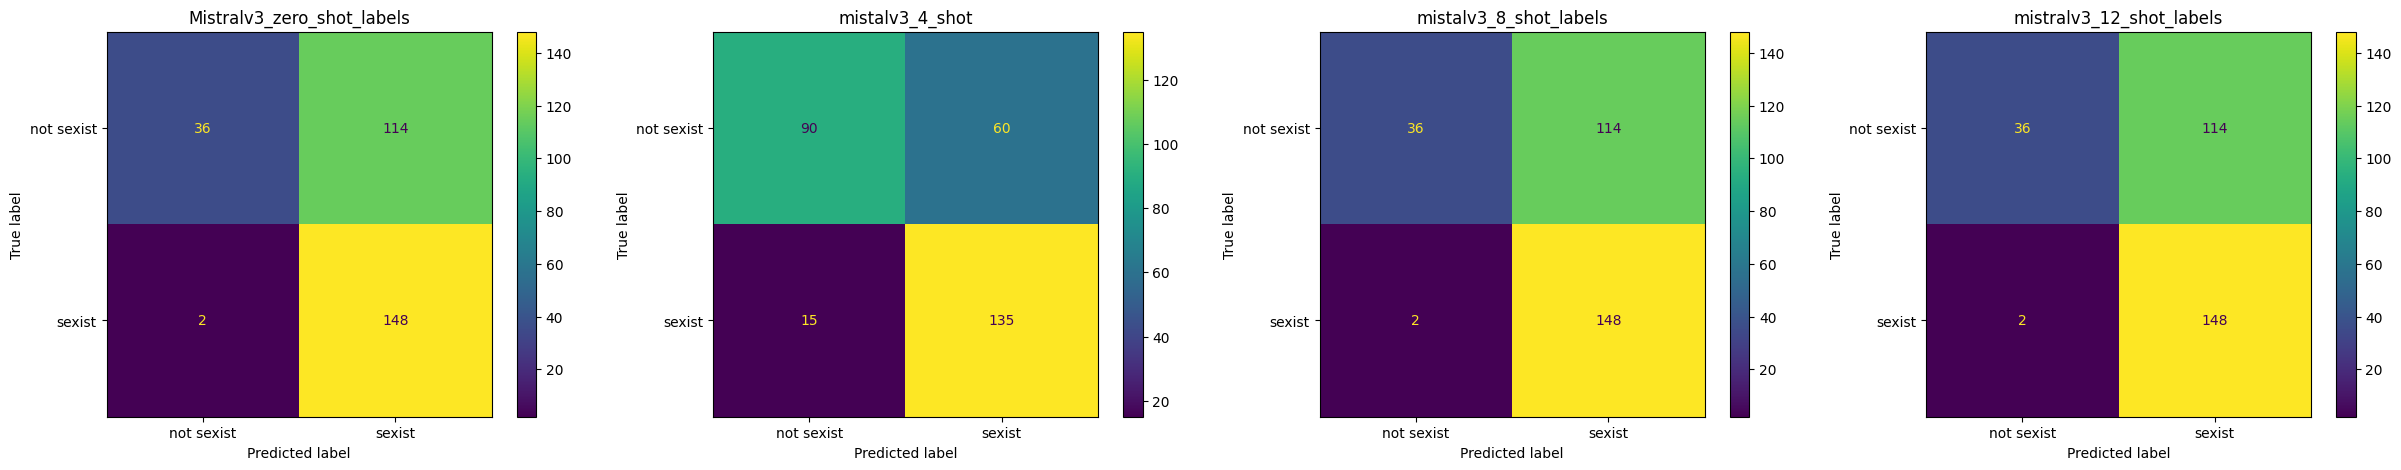

In [50]:
models = ['Mistralv3_zero_shot_labels', 'mistalv3_4_shot', 'mistalv3_8_shot_labels', 'mistralv3_12_shot_labels']
print_models_confusion_matrixs(models, models_predictions)

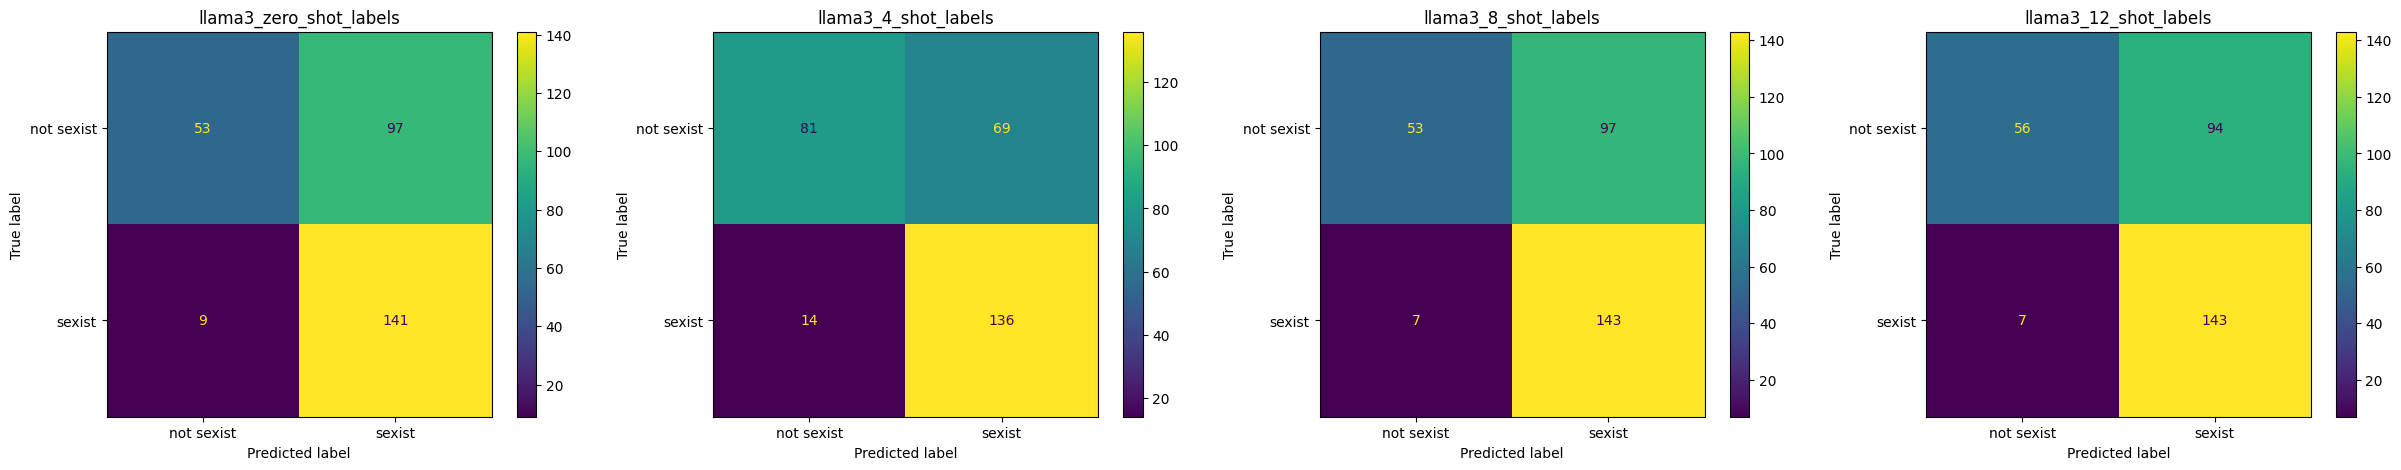

In [63]:
models = ['llama3_zero_shot_labels', 'llama3_4_shot_labels', 'llama3_8_shot_labels', 'llama3_12_shot_labels']
print_models_confusion_matrixs(models, models_predictions)

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End